# Change point detection : Multipoint ruptures

In order to detect many change point in the SNCF TER data we will use sequential methods such as dynamic programming.

To do so we will follow the description given in XXX. 

**ToDo: Write short mathematical description.**

We first start by using a Lasso method to approximate the disared data. The data is then seen as a constant function define by K segments with $K\in\mathbb{N}$. We add to this constant some noise $\sim\mathcal{N}(0,\sigma^2)$.

**ToDo:** Description `Lasso`

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [43]:
def L1_Lasso(data,start,end,lambda_=1):
    """
    Function the realize a lasso cost estimation of the $\beta$ coefficient $\beta = (\beta_1, \ldots, \beta_n)$.
    
    Params:
    =======
        data (array_like): data used to fit the $\beta$ coefficient.
        start (int): beginning of the segment to estimate
        end (int): end of the segment on which we ake the estimation
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        The cost value on this segment.
    """
    if data.ndim == 1:
        data.reshape(-1,1)
    if (end - start) < 2:          # threshold to avoid empty segment
        raise 'EmptySegment'
    segment = data[start:end]
    median = np.median(segment,axis=0)
    cost = lambda_*np.sum(np.abs(segment - median))
    return cost

def L2_Ridge(data,start,end,lambda_=1):
    """
    Function the realize a ridge cost estimation of the $\beta$ coefficient $\beta = (\beta_1, \ldots, \beta_n)$.
    
    Params:
    =======
        data (array_like): data used to fit the $\beta$ coefficient.
        start (int): beginning of the segment to estimate
        end (int): end of the segment on which we ake the estimation
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        The cost value on this segment.
    """
    if data.ndim == 1:
        data.reshape(-1,1)
    if (end - start) < 2:          # threshold to avoid empty segment
        raise 'EmptySegment'
    segment = data[start:end]
    median = np.median(segment,axis=0)
    cost = lambda_*np.sum(np.square(segment - median))
    return cost

In [44]:
from functools import lru_cache

def DynamicProg(data, changepoints,cost=L1_Lasso,lambda_=1, dist_segment=4):
    """
    Find the best subsegment that minimize the cost.
    
    Params:
    =======
        data (array_like): data where we search for change-point.
        dist_segment (int): to create a subsample of data every to $dist_segment$.
        changepoints (int): the number of change-point
        cost (function): which cost function to use
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        a list of change-point.
    """
    
    def recursive(start, end, changepoints, dist_segment=5):
        dist_seg = dist_segment
        # Cas de base
        if changepoints == 0:

            return {(start,end): cost(data,start,end,lambda_)}

        # recurrence
        else:
            dist_segment_list = [i for i in range(start,end) if i%dist_segment==0]

            changepts = []        #list of possible change-points
            for k in dist_segment_list:
                nbs = k - start
                # check for segment availibility
                if changepoints > (nbs//dist_seg) :
                    continue
                if changepoints * np.ceil(2/dist_seg)*dist_seg + 2 > nbs:
                    continue
                if (end - k) >= 2:
                    changepts.append(k)

            # recursive call on both end : right and left side of the cut
            selected = []
            for i in changepts:
                left_side = recursive(start, i,changepoints-1)
                right_side = recursive(i, end,0)

                tmp = dict(left_side)
                tmp[(i,end)] = right_side[(i,end)]
                selected.append(tmp)
                
            return min(selected,key= lambda d: sum(d.values()))
        
    start = 0
    end = data.shape[0]
    points = recursive(start,end,changepoints)
    return sorted(idx for v, idx in points.keys())

In [4]:
import pandas
fichier="regularite-mensuelle-tgv-aqst.csv"

#df = pandas.read_csv(fichier,sep=";")
df=pandas.read_table(fichier,sep=";")
df.head(5)  #  afficher les 5 premières lignes

,Année,Mois,Service,Gare de départ,Gare d'arrivée,Durée moyenne du trajet (min),Nombre de circulations prévues,Nombre de trains annulés,Commentaire (facultatif) annulations,Nombre de trains en retard au départ,...,Retard moyen trains en retard > 15min,Nombre trains en retard > 30min,Nombre trains en retard > 60min,Période,Retard pour causes externes,Retard à cause infrastructure ferroviaire,Retard à cause gestion trafic,Retard à cause matériel roulant,Retard à cause gestion en gare et réutilisation de matériel,Retard à cause prise en compte voyageurs
0,2018,3.0,NaN,STRASBOURG,PARIS EST,112.402439,505.0,13.0,NaN,250.0,...,5.754031,26.0,6.0,2018-03,37.662338,15.584416,19.480519,16.883117,6.493506,3.896104
1,2018,3.0,NaN,PARIS NORD,DUNKERQUE,120.996310,285.0,14.0,NaN,65.0,...,6.697417,19.0,7.0,2018-03,30.769231,17.948718,15.384615,33.333333,2.564103,0.000000
2,2018,3.0,NaN,LYON PART DIEU,PARIS LYON,120.549770,664.0,11.0,NaN,404.0,...,2.210031,12.0,1.0,2018-03,39.215686,5.882353,13.725490,23.529412,15.686275,1.960784
3,2018,3.0,NaN,PARIS LYON,GENEVE,194.005000,203.0,3.0,NaN,26.0,...,0.982500,4.0,0.0,2018-03,25.000000,15.000000,35.000000,10.000000,15.000000,0.000000
4,2018,8.0,NaN,LILLE,MARSEILLE ST CHARLES,309.389535,173.0,1.0,NaN,46.0,...,10.442151,13.0,6.0,2018-08,25.925926,7.407407,18.518519,29.629630,11.111111,7.407407


In [45]:
df=df.sort_values(by=[df.columns[0] , df.columns[1]])
signal = df[df['Gare de départ']=='PARIS LYON']['Nombre de trains annulés'].to_numpy()

result = DynamicProg(signal,1,L2_Ridge,lambda_=1,dist_segment=5)

k_rupture =  [810, 1439]
Paris Est  :  Nombre de trains annulés


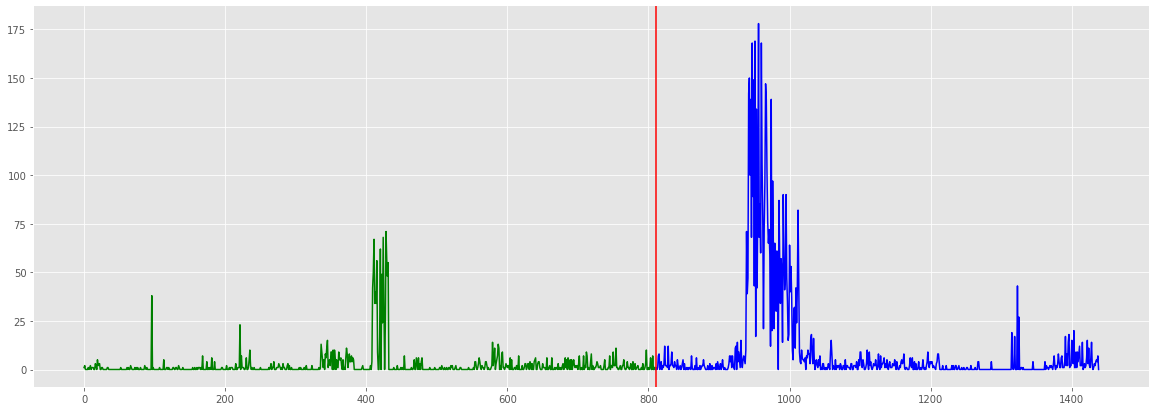

In [46]:

print("k_rupture = ", result)
print('Paris Est', " : ",'Nombre de trains annulés' )
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax1.xaxis.set_ticks_position('bottom')

l1 = [k for k in range(result[0],)]
l2 = [k for k in range(result[0],signal.shape[0])]


plt.plot(l1,signal[:result[0]], color = 'green')
plt.plot(l2,signal[result[0]:result[1]], color = 'blue')

plt.axvline(x=result[0],color='red')


plt.show()

In [19]:
import scipy.stats as stats
m1 = np.mean(signal[:result[0]])
print(m1)
m2 = np.mean(signal[result[0]:result[1]])
m3 = np.mean(signal[result[1]:result[2]])
m4 = np.mean(signal[result[1]:])
print(m2)
sig = np.std(signal)
print(sig)

def normal(x, mu_, sigma_):
    return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)
plt.figure(figsize=(10,7))
x = np.linspace(0,max(signal),10000)
plt.hist(signal,density=True,bins=30)
plt.plot(x,normal(x,m1,sig))
plt.plot(x,normal(x,m2,sig))

2.5405405405405403


IndexError: list index out of range

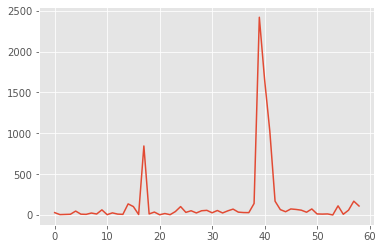

In [22]:
df=df[df['Gare de départ']=='PARIS LYON']
df=df.sort_values(by=[df.columns[0],df.columns[1]])
df=df[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
dd = df.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()

test=pandas.DataFrame(dd,columns=['test'])
plt.plot(test)

k_rupture =  [25]
Paris Lyon  :  Nombre de circulations prévues


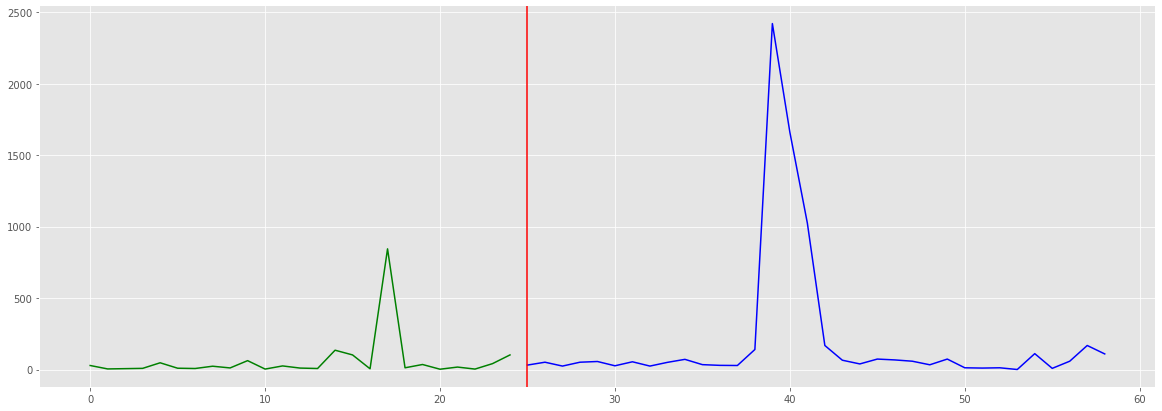

In [49]:
data1 = test['test'].to_numpy()
result1 = DynamicProg(data1,1,L1_Lasso,lambda_=1,dist_segment=1)
result1.pop() 
print("k_rupture = ", result1)
print('Paris Lyon', " : ",'Nombre de circulations prévues' )
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax1.xaxis.set_ticks_position('bottom')

l1 = [k for k in range(result1[0])]
l2 = [k for k in range(result1[0],data1.shape[0])]

plt.plot(l1,data1[:result1[0]], color = 'green')
plt.plot(l2,data1[result1[0]:], color = 'blue')
for i in result1 :
    plt.axvline(x=i,color='red')

plt.show()

k_rupture =  [35]
Paris Lyon  :  Nombre de circulations prévues


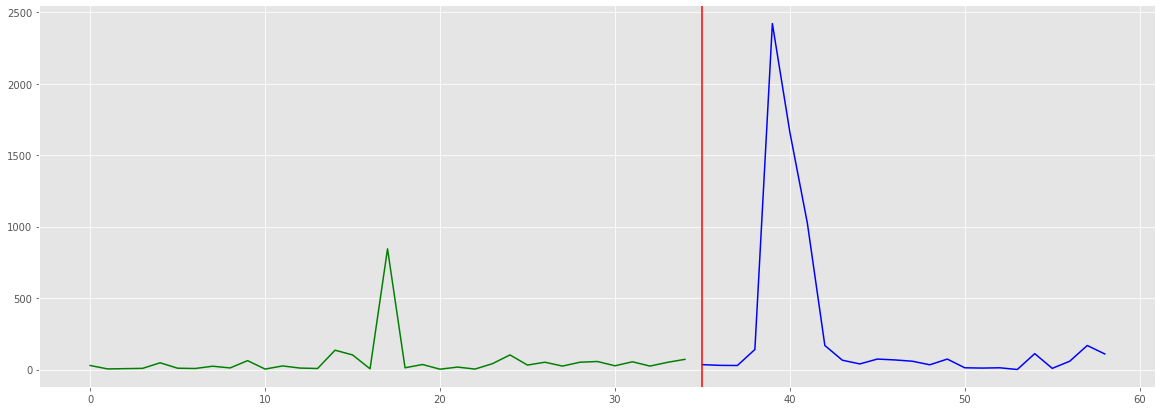

In [50]:
data1 = test['test'].to_numpy()
result1 = DynamicProg(data1,1,L2_Ridge,lambda_=1,dist_segment=1)
result1.pop() 
print("k_rupture = ", result1)
print('Paris Lyon', " : ",'Nombre de circulations prévues' )
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax1.xaxis.set_ticks_position('bottom')

l1 = [k for k in range(result1[0])]
l2 = [k for k in range(result1[0],data1.shape[0])]

plt.plot(l1,data1[:result1[0]], color = 'green')
plt.plot(l2,data1[result1[0]:], color = 'blue')
for i in result1 :
    plt.axvline(x=i,color='red')

plt.show()

k_rupture =  [40, 45]
Paris Lyon  :  Nombre de circulations prévues


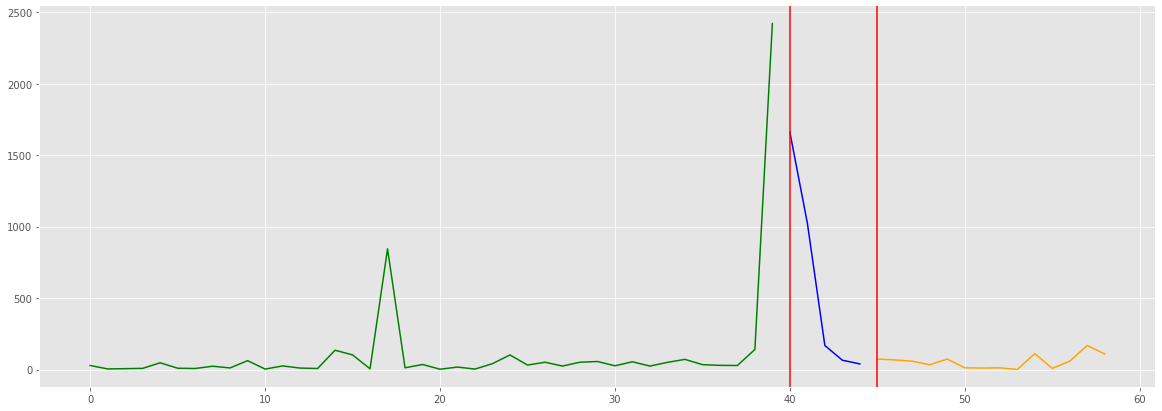

In [60]:
result1 = DynamicProg(data1,2,L1_Lasso,lambda_=1,dist_segment=5)
result1.pop() 
print("k_rupture = ", result1)
print('Paris Lyon', " : ",'Nombre de circulations prévues' )
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax1.xaxis.set_ticks_position('bottom')

l1 = [k for k in range(result1[0])]
l2 = [k for k in range(result1[0],result1[1])]
#l3 = [k for k in range(result1[1],result1[2])]
l4 = [k for k in range(result1[1],data1.shape[0])]

plt.plot(l1,data1[:result1[0]], color = 'green')
plt.plot(l2,data1[result1[0]:result1[1]], color = 'blue')
#plt.plot(l3,data1[result1[1]:result1[2]], color = 'black')
plt.plot(l4,data1[result1[1]:], color = 'orange')
for i in result1 :
    plt.axvline(x=i,color='red')

plt.show()

k_rupture =  [35, 45]
Paris Lyon  :  Nombre de circulations prévues


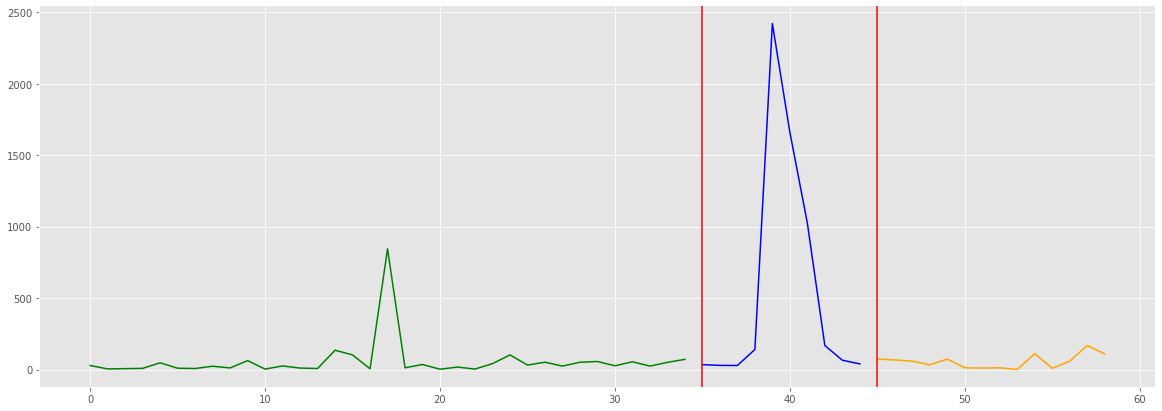

In [61]:
result1 = DynamicProg(data1,2,L2_Ridge,lambda_=1,dist_segment=5)
result1.pop() 
print("k_rupture = ", result1)
print('Paris Lyon', " : ",'Nombre de circulations prévues' )
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax1.xaxis.set_ticks_position('bottom')

l1 = [k for k in range(result1[0])]
l2 = [k for k in range(result1[0],result1[1])]
#l3 = [k for k in range(result1[1],result1[2])]
l4 = [k for k in range(result1[1],data1.shape[0])]

plt.plot(l1,data1[:result1[0]], color = 'green')
plt.plot(l2,data1[result1[0]:result1[1]], color = 'blue')
#plt.plot(l3,data1[result1[1]:result1[2]], color = 'black')
plt.plot(l4,data1[result1[1]:], color = 'orange')
for i in result1 :
    plt.axvline(x=i,color='red')

plt.show()

We can also try a kernel method of change point detection.

In [171]:
from sklearn.metrics.pairwise import polynomial_kernel

def LinearKernel(x,y):
    return np.abs(x-y)

def PolyKernel(x,y,degree=0):
    return polynomial_kernel(x,y,degree)

In [172]:
def Gram(x,kernel):
    """
    Compute a Gram matrix using the specified kernel.
    
    Params:
    =======
        x (array_like): vector of data
        kernel (function): a kernel method $k(x,y)$
    
    Return:
    =======
        The Gram matrix.
    """
    n = x.shape[0]
    x = np.linspace(0,n-1,n).astype(np.int8)
    y = np.linspace(0,n-1,n).astype(np.int8)
    xx,yy = np.meshgrid(x[x],x[y])
    Gram = kernel(xx,yy)
    return Gram

In [176]:
m = Gram(np.linspace(1,10,10),PolyKernel)

In [180]:
def CostMatrix(matrix,nb_segment):
    """
    
    Params:
    =======
        matrix (array_like): a square matrix
    """
    
    n = matrix.shape[0]
    cost_matrix = np.zeros([nb_segment,n])
    index_matrix = np.zeros([nb_segment,n])
    for i in range(0,n):
        cost_matrix[1,i] = matrix[0,i]
    for i in range(1,nb_segment):
        for j in range(i,n):
            min_ = np.min(cost_matrix[i-1,:j] + matrix[:j,j])
            index_matrix[i,j], cost_matrix[i,j] = min_, min_
    return index_matrix, cost_matrix

In [183]:
c,i = CostMatrix(m,4)

In [207]:
def BackTracking(cost_matrix,index_matrix,nb_segment):
    t = np.zeros(nb_segment)
    p = index_matrix.shape[0]
    for i in range(nb_segment):
        p = index_matrix[(nb_segment-1)-i,p].astype(np.int8)
    return t

In [208]:
BackTracking(c,i,4)

array([0., 0., 0., 0.])

In [ ]:
def SegmentCosts(x,gram_matrix):
    n = x.shape[0]
    gamma = np.sum(gram_matrix)
    T = np.sum(np.diag(gram_matrix))
    S = np.zeros([n,n])
    for i in range(n):
        S[0,i] = T[i] - gamma[i,i]/i